In [1]:
from implicit_learning.trainer import PoissonTrainer 
from implicit_learning.model import  ReLU_PE_Model
from implicit_learning.dataset import PoissonEqn
from implicit_learning.utils import *
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader 

import torch
import matplotlib.pyplot as plt 
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [2]:
def construct_dataloader(config):
    sidelength = config['sidelength']
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    train = PoissonEqn(config, transform=transform)
    valid = PoissonEqn(config, transform=transform)
    test  = PoissonEqn(config, transform=transform)
    
    train_dataloader =  DataLoader(train, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    valid_datalodaer =  DataLoader(valid, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    test_dataloader =   DataLoader(test, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)

    return train_dataloader, valid_datalodaer, test_dataloader

class CustomizeTrainer(PoissonTrainer):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, config, beta=0.8):
        self.lr = config.get("lr")
        self.lr_end = config.get("lr_end")
        super().__init__(model, train_dataloader, valid_dataloader, test_dataloader, config)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.print_epoch = config.get("print_epoch")
        self.sidelength = config.get("sidelength")

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                        lr_lambda=lambda epoch: (self.lr + (self.lr_end - self.lr)/self.epochs * epoch),
                                        last_epoch=-1,
                                        verbose=False)
        self.beta = beta 

    def train(self):
        self.model_input = self.model_input.view(-1, 2)
        for epoch in range(self.epochs+1):
            inputs = self.model_input

            self.optimizer.zero_grad() 
            outputs, coords =self.model(inputs)
            grad_loss = self.compute_grad_loss(outputs, coords)
            value_loss = self.compute_value_loss(outputs, coords)
            self.loss = (1- self.beta) * grad_loss + self.beta * value_loss

            if epoch %  self.print_epoch == 0:
                print("--- Epoch %5d/%d  | lr: %.6f---\n"%(epoch, self.epochs, (self.lr + (self.lr_end - self.lr)/self.epochs * epoch)), f" Beta: {self.beta:.3f}", end=" | ")
                print("Loss: %.6f  value_loss: %.6f  grad_loss: %.6f"%(self.loss, value_loss.item(), grad_loss.item()))
                print("PSNR : %.3f | SSIM : %.3f | (GT-GT) PSNR : %.3f | (GT-GT) SSIM : %.3f  "\
                                                    %(self.detach_and_calculate_psnr(outputs, self.gt['pixels']), 
                                                      self.detach_and_calculate_ssim(outputs, self.gt['pixels']),
                                                      self.detach_and_calculate_psnr(self.gt['pixels'], self.gt['pixels']), 
                                                      self.detach_and_calculate_ssim(self.gt['pixels'], self.gt['pixels'])))
                img_grad = gradient(outputs, coords)
                self.plot(outputs, self.gt['pixels'], img_grad, self.gt)

            self.loss.backward()
            self.optimizer.step()
            self.scheduler.step()

    def compute_grad_loss(self, outputs, coords):
        train_loss = self.gradients_mse(outputs, coords, self.gt['grads'])
        return train_loss 

    def compute_value_loss(self, outputs, coords):
        train_loss = ((outputs - self.gt['pixels'])**2).mean()
        return train_loss

    def set_beta(self, beta):
        self.beta = beta 

    def gradients_mse(self, model_output, coords, gt_gradients):
        gradients = gradient(model_output, coords)
        gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
        return gradients_loss

    def detach_and_calculate_psnr(self, model_output, ground_truth):
        model_output = model_output.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        ground_truth = ground_truth.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        return calculate_psnr(model_output, ground_truth)

    def detach_and_calculate_ssim(self, model_output, ground_truth):
        model_output = model_output.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        ground_truth = ground_truth.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        return calculate_ssim(model_output, ground_truth) 

    def plot(self, model_output, original, img_grad, gt):
        # --- image plot
        fig, axes = plt.subplots(1, 4, figsize=(10, 5))
        axes[0].imshow(model_output.cpu().view(self.sidelength,self.sidelength).detach().numpy())
        axes[1].imshow(original.cpu().view(self.sidelength,self.sidelength).detach().numpy())
        axes[2].imshow(img_grad.cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy())
        axes[3].imshow(gt['grads'].cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy())
        axes[0].set_title("Pred values")
        axes[1].set_title("GT values")
        axes[2].set_title("Pred grads")
        axes[3].set_title("GT grads")
        
        # --- histogram 
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].hist(model_output.flatten().cpu().detach().numpy(), bins=200,log=True, alpha=0.5)
        axes[0].hist(gt['pixels'].flatten().cpu().detach().numpy(), bins=200,log=True, alpha=0.5)
        axes[0].legend(["model", "ground truth"])
        axes[0].set_title("value histogram")
        axes[1].hist(img_grad.view(1, self.sidelength, self.sidelength,2)[:,:,:,0].flatten().cpu().detach().numpy(), bins=200,log=True, alpha=0.5)
        axes[1].hist(gt['grads'].view(1, self.sidelength, self.sidelength,2)[:,:,:,0].flatten().cpu().detach().numpy(), bins=200,log=True, alpha=0.5)
        axes[1].legend(["model", "ground truth"])
        axes[1].set_title("grad histogram")
        plt.tight_layout()
        plt.show()

--- Epoch     0/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.241658  value_loss: 0.219026  grad_loss: 2.482243
PSNR : 54.726 | SSIM : -0.215 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


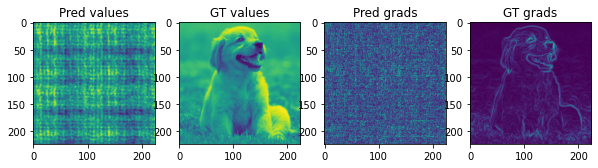

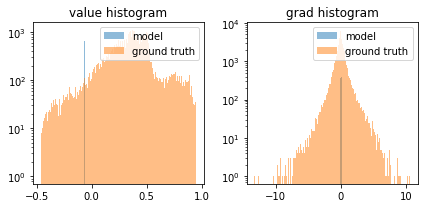

--- Epoch   100/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.070638  value_loss: 0.043416  grad_loss: 2.765678
PSNR : 61.754 | SSIM : 0.545 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


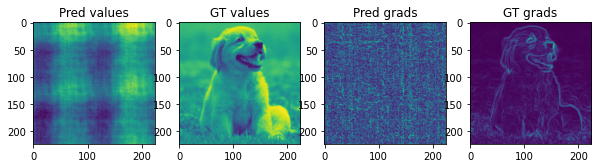

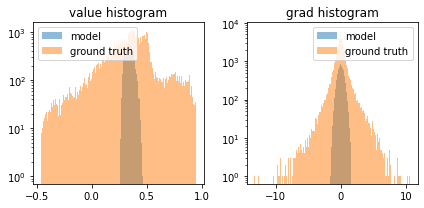

--- Epoch   200/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.062173  value_loss: 0.035806  grad_loss: 2.672532
PSNR : 62.591 | SSIM : 0.556 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


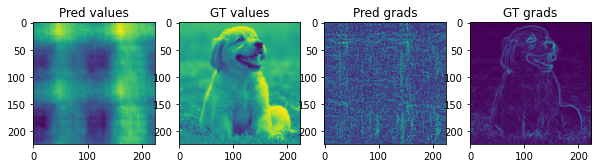

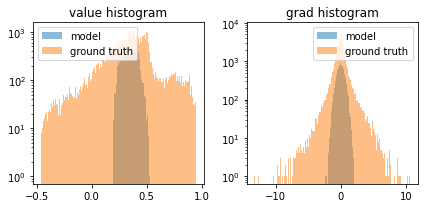

--- Epoch   300/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.053038  value_loss: 0.027330  grad_loss: 2.598115
PSNR : 63.764 | SSIM : 0.576 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


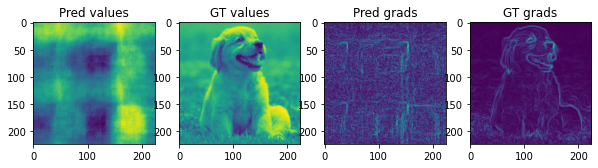

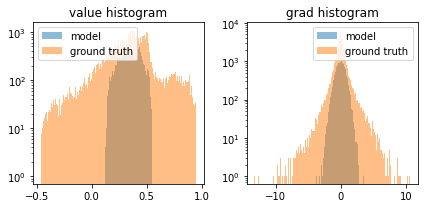

--- Epoch   400/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.045497  value_loss: 0.021632  grad_loss: 2.408159
PSNR : 64.780 | SSIM : 0.598 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


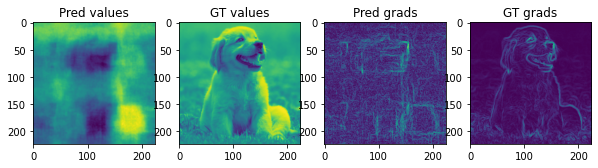

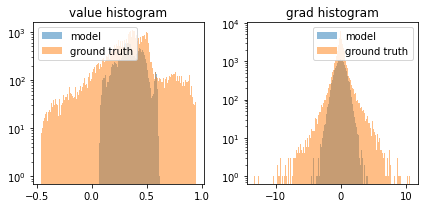

--- Epoch   500/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.039069  value_loss: 0.017277  grad_loss: 2.196526
PSNR : 65.756 | SSIM : 0.621 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


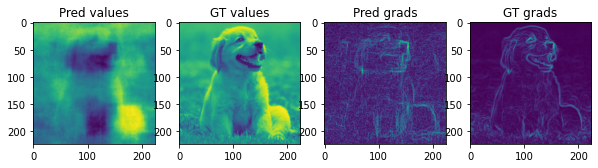

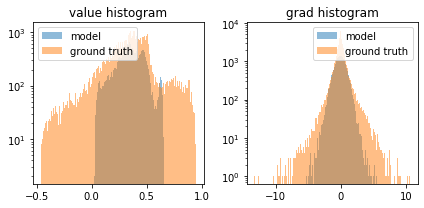

--- Epoch   600/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.034188  value_loss: 0.014421  grad_loss: 1.991082
PSNR : 66.541 | SSIM : 0.643 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


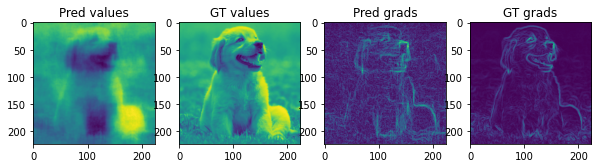

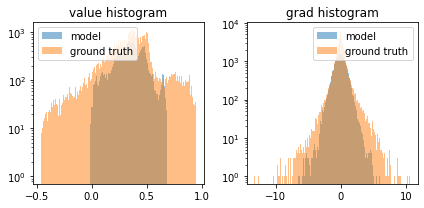

--- Epoch   700/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.030606  value_loss: 0.012583  grad_loss: 1.814931
PSNR : 67.133 | SSIM : 0.660 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


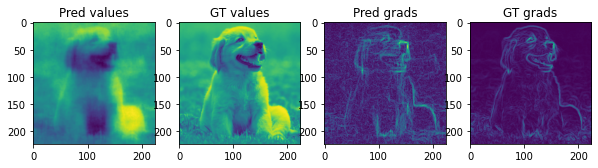

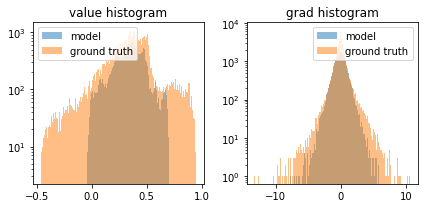

--- Epoch   800/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.027971  value_loss: 0.011435  grad_loss: 1.665061
PSNR : 67.549 | SSIM : 0.671 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


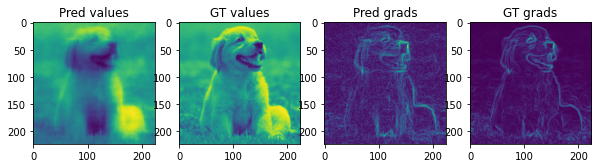

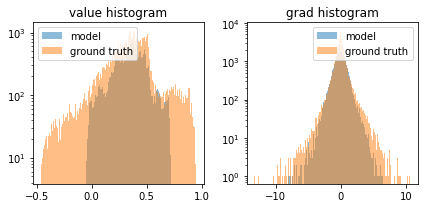

--- Epoch   900/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.026212  value_loss: 0.010660  grad_loss: 1.565895
PSNR : 67.853 | SSIM : 0.678 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


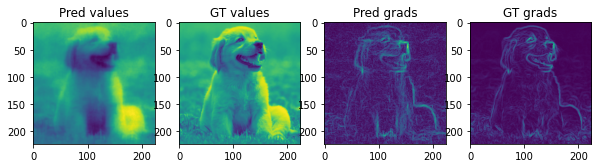

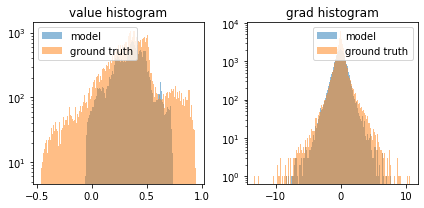

--- Epoch  1000/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.025080  value_loss: 0.010211  grad_loss: 1.497119
PSNR : 68.040 | SSIM : 0.684 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


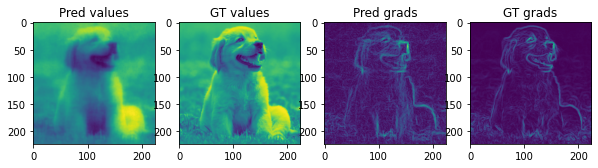

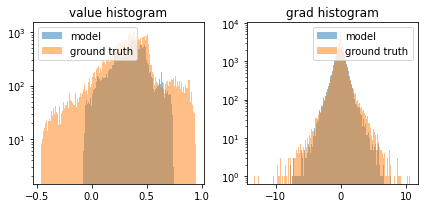

--- Epoch  1100/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.024325  value_loss: 0.009945  grad_loss: 1.447945
PSNR : 68.155 | SSIM : 0.689 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


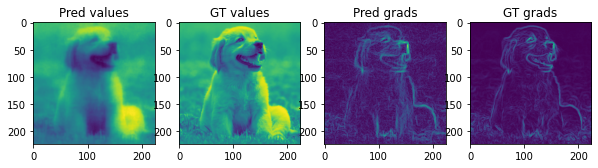

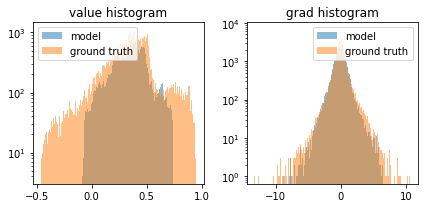

--- Epoch  1200/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.023747  value_loss: 0.009703  grad_loss: 1.414177
PSNR : 68.262 | SSIM : 0.693 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


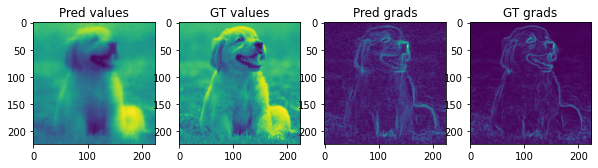

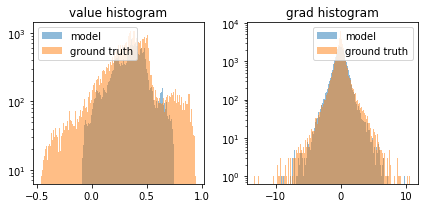

--- Epoch  1300/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.023193  value_loss: 0.009519  grad_loss: 1.376897
PSNR : 68.345 | SSIM : 0.695 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


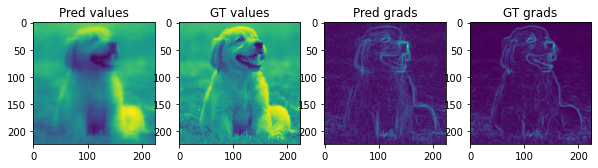

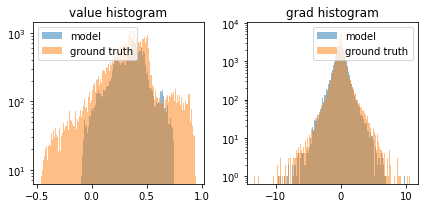

--- Epoch  1400/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.022588  value_loss: 0.009360  grad_loss: 1.332179
PSNR : 68.418 | SSIM : 0.698 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


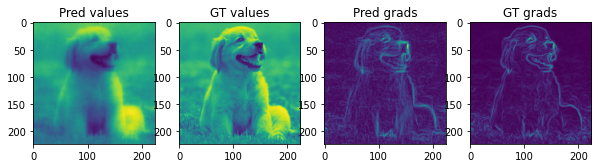

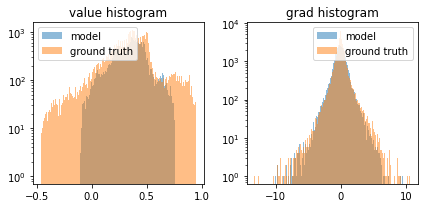

--- Epoch  1500/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.022235  value_loss: 0.009249  grad_loss: 1.307850
PSNR : 68.470 | SSIM : 0.700 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


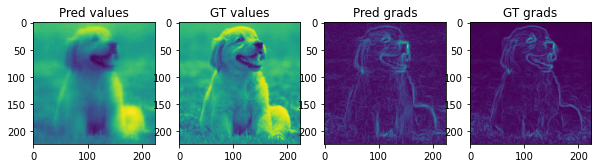

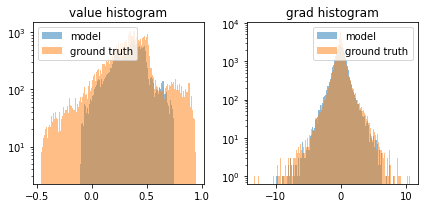

--- Epoch  1600/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021854  value_loss: 0.009125  grad_loss: 1.282026
PSNR : 68.529 | SSIM : 0.702 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


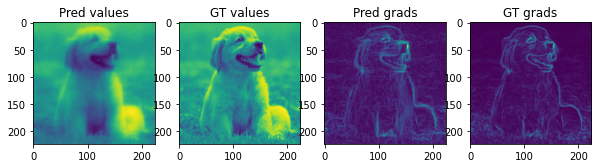

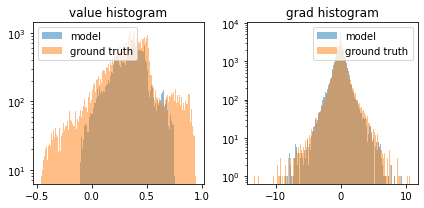

--- Epoch  1700/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021827  value_loss: 0.009065  grad_loss: 1.285196
PSNR : 68.557 | SSIM : 0.700 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


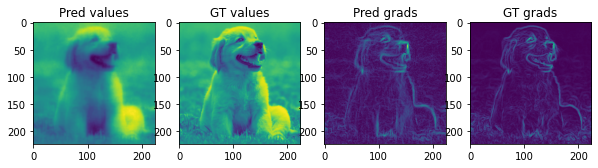

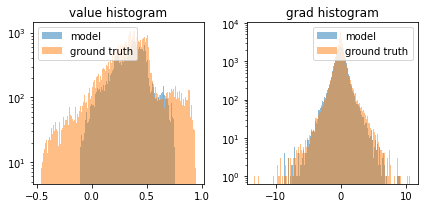

--- Epoch  1800/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021655  value_loss: 0.009001  grad_loss: 1.274331
PSNR : 68.588 | SSIM : 0.702 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


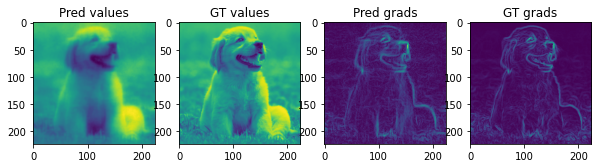

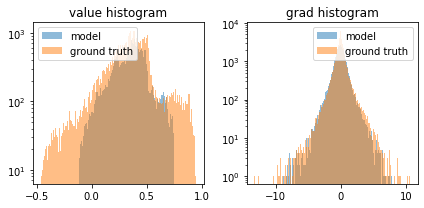

--- Epoch  1900/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021627  value_loss: 0.008974  grad_loss: 1.274333
PSNR : 68.601 | SSIM : 0.703 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


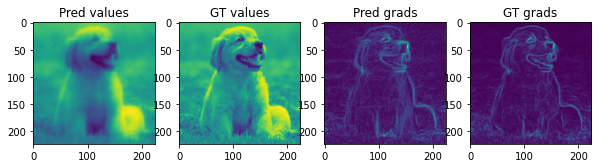

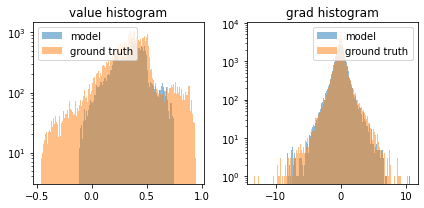

--- Epoch  2000/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021807  value_loss: 0.009021  grad_loss: 1.287615
PSNR : 68.578 | SSIM : 0.702 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


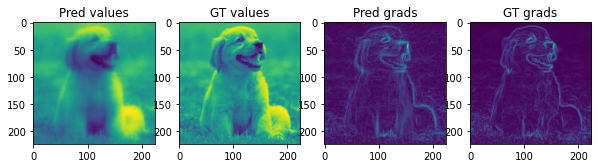

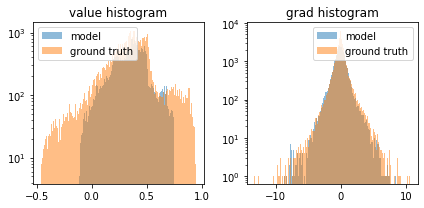

--- Epoch  2100/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021971  value_loss: 0.009011  grad_loss: 1.305006
PSNR : 68.583 | SSIM : 0.701 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


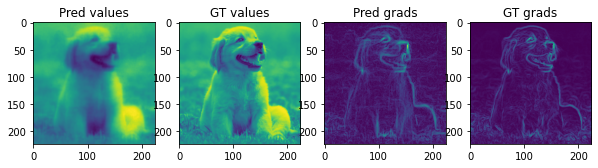

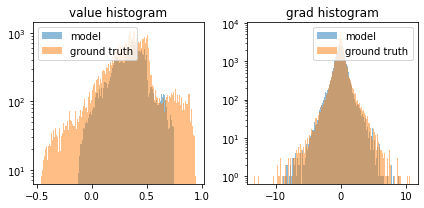

--- Epoch  2200/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021774  value_loss: 0.008945  grad_loss: 1.291831
PSNR : 68.615 | SSIM : 0.701 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


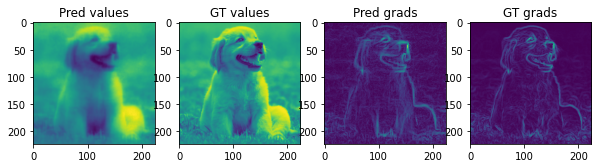

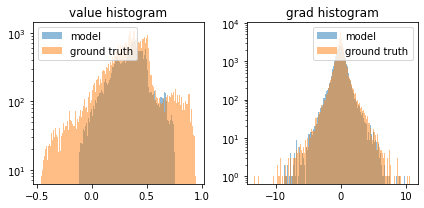

--- Epoch  2300/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021889  value_loss: 0.008922  grad_loss: 1.305573
PSNR : 68.626 | SSIM : 0.701 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


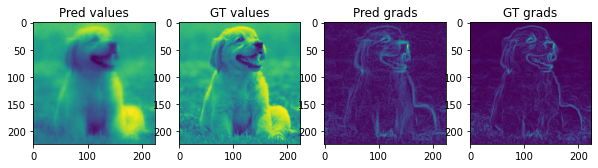

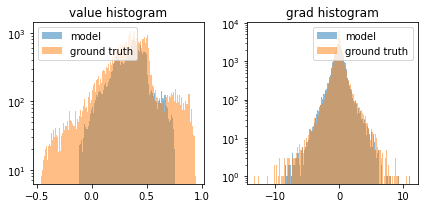

--- Epoch  2400/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021789  value_loss: 0.008898  grad_loss: 1.297958
PSNR : 68.638 | SSIM : 0.702 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


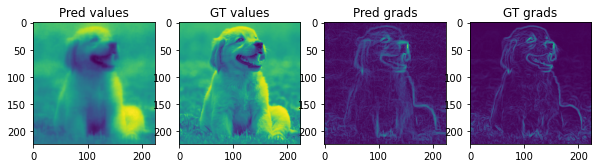

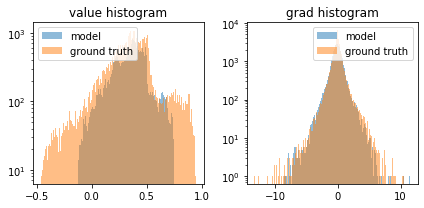

--- Epoch  2500/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021525  value_loss: 0.008865  grad_loss: 1.274798
PSNR : 68.654 | SSIM : 0.704 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


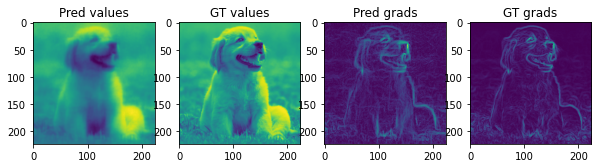

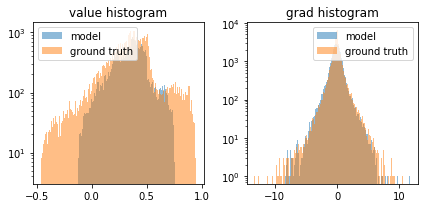

--- Epoch  2600/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021624  value_loss: 0.008879  grad_loss: 1.283452
PSNR : 68.647 | SSIM : 0.704 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


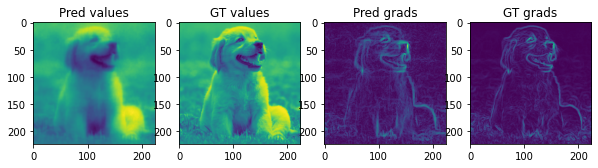

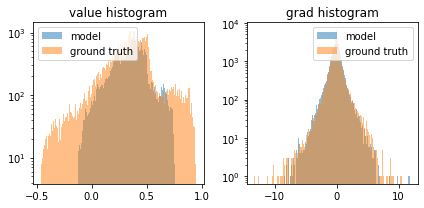

--- Epoch  2700/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021877  value_loss: 0.008880  grad_loss: 1.308561
PSNR : 68.647 | SSIM : 0.703 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


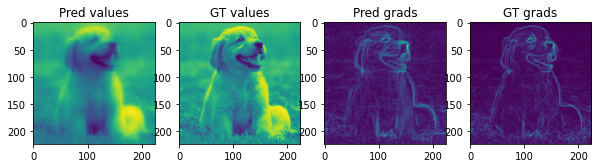

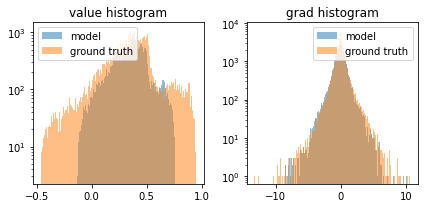

--- Epoch  2800/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021806  value_loss: 0.008859  grad_loss: 1.303519
PSNR : 68.657 | SSIM : 0.703 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


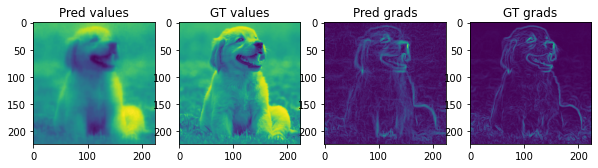

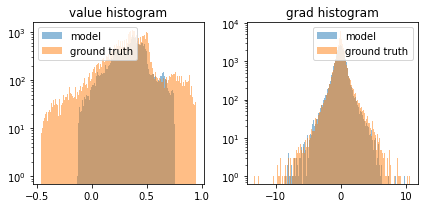

--- Epoch  2900/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021793  value_loss: 0.008831  grad_loss: 1.305037
PSNR : 68.671 | SSIM : 0.703 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


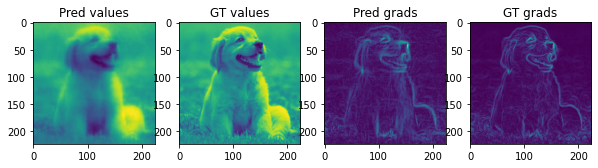

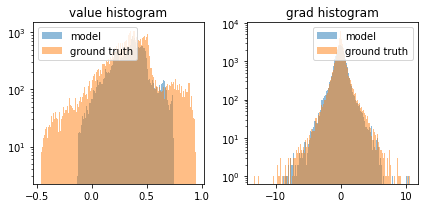

--- Epoch  3000/4000  | lr: 0.010000---
  Beta: 0.990 | Loss: 0.021829  value_loss: 0.008826  grad_loss: 1.309202
PSNR : 68.673 | SSIM : 0.702 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


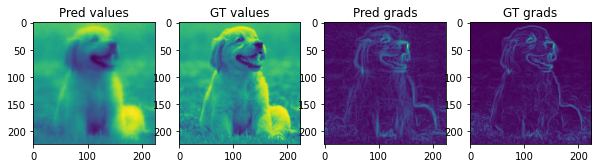

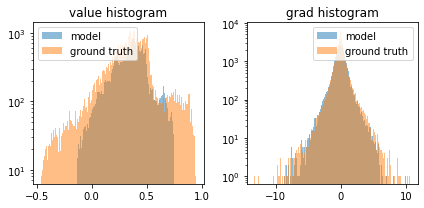

KeyboardInterrupt: 

In [4]:

config = {
    "model":{
        "in_features":2,
        "hidden_features":224,
        "hidden_layers":5,
        "out_features":1,
        "L":5
    },
    "sidelength":224,
    "epochs":4000,
    "lr":0.01,
    "lr_end":0.01,
    "batch_size":1,
    "data-path":"../../data/dog224.png",
    "print_epoch":100
}

model = ReLU_PE_Model(**config['model'])
model.cuda()
trainer = CustomizeTrainer(model, *construct_dataloader(config), config, beta=0.99)

trainer.train()